<a href="https://www.kaggle.com/code/sushovansaha9/langgraph-multiagent-code-chat-qwen-gemma?scriptVersionId=208636173" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install -qq langgraph
!pip install -qq langchain
!pip install -qq accelerate
!pip install -qq pygraphviz
!pip install -qq -i https://pypi.org/simple/ bitsandbytes

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 24.8.3 requires cubinlinker, which is not installed.
cudf 24.8.3 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 24.8.3 requires ptxcompiler, which is not installed.
cuml 24.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 24.8.3 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 24.8.3 requires cuda-python<12.0a0,>=11.7.1, but you have cuda-python 12.6.0 which is incompatible.
distributed 2024.7.1 requires dask==2024.7.1, but you have dask 2024.9.1 which is incompatible.
google-cloud-bigquery 2.34.4 requires packaging<22.0dev,>=14.3, but you have packaging 24.2 which is incompatible.
jupyterlab 4.2.5 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
jupyterlab-lsp 5.1.0 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which 

## Gemma2b for Casual Chat

In [2]:
from transformers import AutoTokenizer, AutoModelForCausalLM
# Load the model
tokenizer = AutoTokenizer.from_pretrained("/kaggle/input/gemma/transformers/2b-it/3")
model = AutoModelForCausalLM.from_pretrained("/kaggle/input/gemma/transformers/2b-it/3")

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
model

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear(in_features=16384, out_features=2048, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): GemmaRMSNorm((2048,), eps=1e-06)
        (post_attention_layernorm): GemmaRMSNorm((2048,), eps=1e-

In [4]:
from langchain.prompts import PromptTemplate
from transformers import TextStreamer,pipeline
import torch

In [5]:
pipe =  pipeline(task = 'text-generation',
                         model = model,
                         tokenizer = tokenizer,
                         temperature=0.5,  # 'randomness' of outputs, 0.0 is the min and 1.0 the max
                         top_p=0.25,  # select from top tokens whose probability add up to 15%
                         top_k=0,  # select from top 0 tokens (because zero, relies on top_p)
                         max_new_tokens=10,  # mex number of tokens to generate in the output
                         repetition_penalty=1.1,  # without this output begins repeating
                         model_kwargs={"torch_dtype": torch.bfloat16},
                         device="cuda",
                )

In [6]:
prompt_template = """answer the question in less than 30 words and do not hallucinate.
Question : {question}
Answer : """


PROMPT = PromptTemplate(
    template = prompt_template, 
    input_variables = ["question"]
)

In [7]:
PROMPT.format(question="How are you ?")

'answer the question in less than 30 words and do not hallucinate.\nQuestion : How are you ?\nAnswer : '

In [8]:
outputs = pipe(
    	PROMPT.format(question="How are you ?"),
    	max_new_tokens=256,
    	add_special_tokens=True,
    	do_sample=True,
    	temperature=0.7,
    	top_k=50,
    	top_p=0.95
    )
print(outputs[0]["generated_text"])

Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


answer the question in less than 30 words and do not hallucinate.
Question : How are you ?
Answer : 
I am alive and well, thanks to the magic of life.


In [9]:
def GemmaSearch(question):
    outputs = pipe(
    	PROMPT.format(question=question),
    	max_new_tokens=256,
    	add_special_tokens=True,
    	do_sample=True,
    	temperature=0.7,
    	top_k=50,
    	top_p=0.95
    )
    return outputs[0]["generated_text"]

## Qwen2.5 for Coding

In [10]:
model_name = "/kaggle/input/qwen2.5-coder/transformers/1.5b-instruct/1"

qwenmodel = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto",
    device_map="auto"
)
qwentokenizer = AutoTokenizer.from_pretrained(model_name)


In [11]:
def QwenCoder(question):
   
    messages = [
        {"role": "system", "content": "Write code for the given query. do not hallucinate"},
        {"role": "user", "content": question}
    ]
    text = qwentokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )
    model_inputs = qwentokenizer([text], return_tensors="pt").to(model.device)
    
    generated_ids = qwenmodel.generate(
        **model_inputs,
        max_new_tokens=512
    )
    generated_ids = [
        output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
    ]
    
    response = qwentokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return response

In [12]:
ans = QwenCoder("Write python code for bubble sort")
print(ans)

Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


Sure, here's a simple Python implementation of the Bubble Sort algorithm:

```python
def bubble_sort(arr):
    n = len(arr)
    
    # Traverse through all array elements
    for i in range(n):
        # Last i elements are already in place
        for j in range(0, n-i-1):
            # Traverse the array from 0 to n-i-1
            # Swap if the element found is greater than the next element
            if arr[j] > arr[j+1]:
                arr[j], arr[j+1] = arr[j+1], arr[j]

# Example usage:
arr = [64, 34, 25, 12, 22, 11, 90]
bubble_sort(arr)
print("Sorted array:", arr)
```

This code defines a function `bubble_sort` that takes an array as input and sorts it using the Bubble Sort algorithm. The outer loop iterates over each element in the array, while the inner loop compares adjacent elements and swaps them if they are in the wrong order. This process repeats until the entire array is sorted.


In [13]:
from typing import Dict, TypedDict, Optional

In [14]:
class GraphState(TypedDict):
    question: Optional[str] = None
    classification: Optional[str] = None
    response: Optional[str] = None

In [15]:
from langgraph.graph import StateGraph,END 

In [16]:
workflow = StateGraph(GraphState)

In [17]:
def classify(input_data):
    
    # Define simple rules for classification
    greetings = {"hello", "hi", "hey", "good morning", "good evening"}

    coder = {"write code", "code", "algorithm","programming", "c code", "python"}

    # Preprocess the input (e.g., convert to lowercase)
    processed_input = input_data.lower()

    # Classify based on keywords
    if any(word in processed_input for word in greetings): return "greeting"
    elif any(word in processed_input for word in coder): return "code"
    else: return "unknown"  # Default or fallback classification


## Agents

In [18]:
def classify_input_node(state):
    question = state.get('question', '').strip()
    classification = classify(question)  # Assume a function that classifies the input
    return {"classification": classification}
    
def handle_greeting_node(state):
    return {"response": "Hello! How can I help you today?"}
    
def handle_search_node(state):
    question = state.get('question', '').strip()
    answer = GemmaSearch(question)
    return {"response": answer}


def coder_node(state):
    question = state.get('question', '').strip()
    answer = QwenCoder(question)
    return {"response": answer}

In [19]:
def decide_next_node(state):
    if state.get('classification') == "greeting": 
        return "handle_greeting" 
    elif state.get('classification') == "code" : 
        return "qwen_coder" 
    else : 
        return "handle_search"

## Building the LangGraph

In [20]:
workflow.add_node("classify_input", classify_input_node)
workflow.add_node("handle_greeting", handle_greeting_node)
workflow.add_node("handle_search", handle_search_node)
workflow.add_node("qwen_coder",coder_node)


workflow.add_conditional_edges(
    "classify_input",
    decide_next_node,
    {
        "handle_greeting": "handle_greeting",
        "handle_search": "handle_search",
        "qwen_coder" : "qwen_coder"
    }
)

In [21]:
workflow.set_entry_point("classify_input")
workflow.add_edge('handle_greeting', END)
workflow.add_edge('handle_search', END)
workflow.add_edge('qwen_coder', END)

In [22]:
app = workflow.compile()

## Graph Visualization

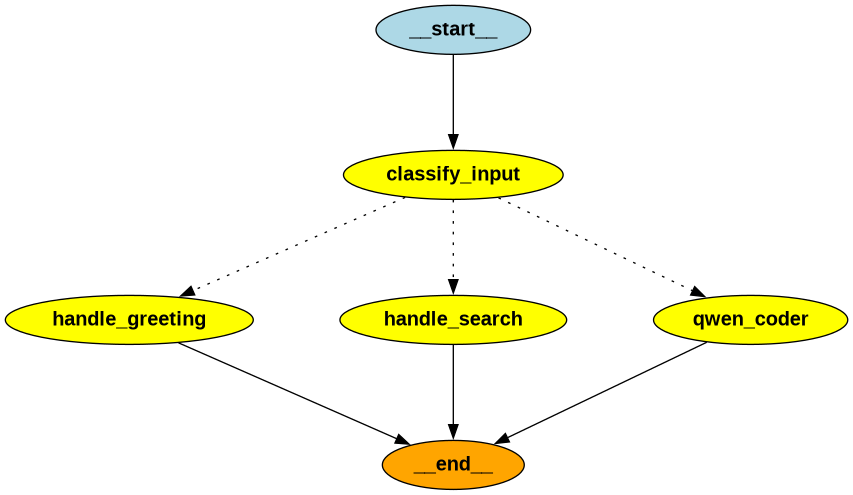

In [23]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_png()))

## Results

In [26]:
inputs = {"question": "Hello, how are you?"}
result = app.invoke(inputs)
print(result['classification'])
print(result['response'])

greeting
Hello! How can I help you today?


In [27]:
inputs = {"question": "Who is the greatest footballer of all time ?"}
result = app.invoke(inputs)
print(result['classification'])
print(result['response'])

unknown
answer the question in less than 30 words and do not hallucinate.
Question : Who is the greatest footballer of all time ?
Answer : <u>Ronaldo</u>. He is widely considered to be one of the greatest footballers of all time.


In [28]:
inputs = {"question": "write code for Longest Common Subsequence."}
result = app.invoke(inputs)
print(result['classification'])
print(result['response'])

code
Certainly! Below is a Python implementation of the Longest Common Subsequence (LCS) algorithm:

```python
def longest_common_subsequence(X, Y):
    m = len(X)
    n = len(Y)

    # Create a 2D array to store lengths of LCS of substrings
    L = [[0] * (n + 1) for _ in range(m + 1)]

    # Build the L[m+1][n+1] table in bottom-up manner
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            if X[i - 1] == Y[j - 1]:
                L[i][j] = L[i - 1][j - 1] + 1
            else:
                L[i][j] = max(L[i - 1][j], L[i][j - 1])

    # Following line prints the length of LCS
    print("Length of LCS is", L[m][n])

    # Print the LCS
    index = L[m][n]
    lcs = [""] * index

    while m > 0 and n > 0:
        if X[m - 1] == Y[n - 1]:
            lcs[index - 1] = X[m - 1]
            m -= 1
            n -= 1
            index -= 1
        elif L[m - 1][n] > L[m][n - 1]:
            m -= 1
        else:
            n -= 1

    print("LCS is:", "".join(lcs)